# Prepare the workspace

In [1]:
# Check torch version and CUDA status if GPU is enabled.
import torch
print(torch.__version__)
print(torch.cuda.is_available()) # Should return True when GPU is enabled. 

2.3.1
False


# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [2]:
# Imports here

# Numerical computation
import numpy as np  

# Deep learning framework 
import torchvision  
from torchvision import datasets, transforms, models  
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

# Image handling
from PIL import Image  

# Visualization
import matplotlib.pyplot as plt  

# File and system operations
import sys  # Provides access to system-specific parameters & functions
import os  # Enables interaction with the operating system (file paths)
import json  # Handles category label mappings
import argparse  # Enables command-line arguments
import time  # Tracks training performance & execution time
import gc  # Manages garbage collection to free unused memory
import psutil  # Monitors system memory & CPU usage
from tqdm import tqdm  # Progress bar for better visualization

# Model features
from collections import OrderedDict # For organizing model layers
import copy  # For deep copying models (useful in saving checkpoints)

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). 

If you do not find the `flowers/` dataset in the current directory, **/workspace/home/aipnd-project/**, you can download it using the following commands. 

**Method 1**
```bash
!wget 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz'
!unlink flowers
!mkdir flowers && tar -xzf flower_data.tar.gz -C flowers
```


**Method 2**
```bash
!cp -r /data/ .
```

## Data Description
The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
def get_input_args():
    """
    Parses command-line arguments for configuring the image classification model.
    This function allows users to specify input data, model type, and class labels.

    Supports execution in both:
    - **Command Line**: Accepts user-provided arguments.
    - **Jupyter Notebook**: Uses default arguments to prevent kernel-related errors.

    Command Line Arguments:
      1. Image Folder as `--data_dir` (default: 'flowers')
      2. CNN Model Architecture as `--model` (default: 'vgg13')
      3. JSON File with Flower Names as `--flower_names` (default: 'cat_to_name.json')

    Additionally, it sets predefined paths for training, validation, and test data:
      - `train_dir`: Training data path (`data_dir/train`)
      - `valid_dir`: Validation data path (`data_dir/valid`)
      - `test_dir`: Test data path (`data_dir/test`)

    Returns:
      args: Parsed arguments object containing `data_dir`, `model`, `flower_names`, and dataset paths.
    """
    # Create ArgumentParser object
    parser = argparse.ArgumentParser(description="Parse input arguments for image classification.")

    # Get the current working directory dynamically
    base_path = os.getcwd()

    # Define command-line arguments
    parser.add_argument('--data_dir', type=str, 
                        default=os.path.join(base_path, 'flowers'), 
                        help="Path to the dataset root directory.")     

    parser.add_argument('--model', type=str, default="resnet50", choices=["resnet18", "resnet50"],
                        help="Model Architecture to be used: resnet18 (CPU) or resnet50 (GPU).")  

    parser.add_argument('--flower_names', type=str, 
                        default=os.path.join(base_path, 'cat_to_name.json'),
                        help="Path to the JSON file mapping class labels to flower names.")

    # Determine execution environment
    if "ipykernel" in sys.modules:
        # Running inside Jupyter Notebook: Ignore unexpected arguments
        args = parser.parse_args(args=[])
    else:
        # Running in Command Line: Use actual arguments
        args = parser.parse_args()

    # Add dataset directory mappings
    args.train_dir = os.path.join(args.data_dir, 'train')
    args.valid_dir = os.path.join(args.data_dir, 'valid')
    args.test_dir = os.path.join(args.data_dir, 'test')

    # Debugging output
    print("\n[INFO] Parsed Input Arguments:")
    print(f"  - Data folder: {args.data_dir}")
    print(f"  - Training data folder: {args.train_dir}")
    print(f"  - Validation data folder: {args.valid_dir}")
    print(f"  - Testing data folder: {args.test_dir}")
    print(f"  - Model architecture: {args.model}")
    print(f"  - Flower names file: {args.flower_names}\n")

    return args


In [4]:
# Call the function
if __name__ == "__main__":
    args = get_input_args()


[INFO] Parsed Input Arguments:
  - Data folder: C:\Users\camel\Desktop\Projects\MY_COURSE\second_project\udacity_AIPND_train_flower_network\flowers
  - Training data folder: C:\Users\camel\Desktop\Projects\MY_COURSE\second_project\udacity_AIPND_train_flower_network\flowers\train
  - Validation data folder: C:\Users\camel\Desktop\Projects\MY_COURSE\second_project\udacity_AIPND_train_flower_network\flowers\valid
  - Testing data folder: C:\Users\camel\Desktop\Projects\MY_COURSE\second_project\udacity_AIPND_train_flower_network\flowers\test
  - Model architecture: resnet50
  - Flower names file: C:\Users\camel\Desktop\Projects\MY_COURSE\second_project\udacity_AIPND_train_flower_network\cat_to_name.json



In [5]:
print(os.path.exists(args.train_dir))
print(os.path.exists(args.valid_dir))
print(os.path.exists(args.test_dir))

True
True
True


 For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. 
    This will help the network generalize leading to better performance. 
    You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. 
For this you don't want any scaling or rotation transformations, 
but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. 
For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. 
For the means, it's [0.485, 0.456, 0.406] and for the standard deviations [0.229, 0.224, 0.225], 
calculated from the ImageNet images. 
These values will shift each color channel to be centered at 0 and range from -1 to 1.


# Defining data transformations, loading image datasets and creating dataloaders


In [6]:
# TODO: Define your transforms for the training, validation, and testing sets

# Transforms are common image transformations. They can be chained together using Compose. 

data_transform_train = transforms.Compose([
    # transforms.Resize(256, interpolation=transforms.InterpolationMode.NEAREST), # Make sure image is large enough and stays sharp
    transforms.RandomResizedCrop(224, ratio=(1.0, 1.0), scale=(0.8, 1.0)), # Random scaling & cropping
    # Note this function randomly resizes the image (scaling up or down) and then crops a 224x224 region.
    # Using a less aggresive crop because the model was performing much more poorly in train than in eval.
    transforms.RandomHorizontalFlip(),  # Flipping after cropping
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet mean & SD
])
 
data_transform_validtest = transforms.Compose([
    transforms.Resize(256),  # Resize keeping aspect ratio
    transforms.CenterCrop(224),  # Crop to 224x224 (centered)
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet mean & SD
])

In [7]:
# TODO: Load the datasets with ImageFolder

train_dataset = torchvision.datasets.ImageFolder(root=args.train_dir, transform = data_transform_train)
valid_dataset = torchvision.datasets.ImageFolder(root=args.valid_dir, transform = data_transform_validtest)
test_dataset = torchvision.datasets.ImageFolder(root=args.test_dir, transform = data_transform_validtest)    

In [8]:
# Sanity check: look into the tensor of a single transformed image

image = train_dataset[0][0]  #Get the first image (index 0)
print(f"Image shape: {image.shape}")  #Expected: (3, 224, 224)
print(f"Image tensor min: {image.min()}, max: {image.max()}")  #ImageNet normalization produces values between ~ -2.12 and 2.64.

data_transform_train_check = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # Removing Normalization for checking
])

train_dataset_check = datasets.ImageFolder(root=args.train_dir, transform=data_transform_train_check)
image = train_dataset[0][0] 
print(f"Image min: {image.min()}, max: {image.max()}")

# Delete the dataset and transformation of this quick sanity check
del train_dataset_check
del data_transform_train_check

Image shape: torch.Size([3, 224, 224])
Image tensor min: -2.1179039478302, max: 2.6225709915161133
Image min: -2.1179039478302, max: 2.6225709915161133


In [9]:
# TODO: Using the image datasets and the trainforms, define the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size= 32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size= 32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size= 32, shuffle=False)

# Adapted settings for CPU
# train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=False)
# valid_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=False)
# test_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=False)

# Checks on the transformations and batches

In [10]:
def process_image(folder_number, image_index, subset_dir, transform):
    """
    Loads an image from a specified folder and image index, applies the given transform,
    and returns both the original image (before any transform) and the transformed image.
    
    Parameters:
        folder_number (int): The flower category folder number (1 to 102).
                             If out of range, defaults to 1.
        image_index (int): The index of the image within that folder (e.g., 0 for the first image).
                           If higher than the available number, defaults to 0.
        subset_dir (str): Root directory for the subset (e.g., train, valid, or test folder).
        transform (callable): A torchvision transform appropriate for this subset.
                              This transform should include normalization with:
                              mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].
    
    Returns:
        original_image (PIL.Image.Image): The original image loaded from disk (before transform).
        processed_image (torch.Tensor): The image tensor after applying the given transform.
        denormalized_image (numpy.ndarray): The de-normalized image (H, W, C) for visualization.
    """

    # Ensure folder_number is between 1 and 102 (default to 1 if out of range)
    if folder_number < 1 or folder_number > 102:
        print(f"Warning: folder_number {folder_number} is out of range. Defaulting to 1.")
        folder_number = 1

    # Build the folder path (e.g., "train/5" if folder_number is 5)
    class_folder = os.path.join(subset_dir, str(folder_number))
    if not os.path.isdir(class_folder):
        raise ValueError(f"Folder '{class_folder}' does not exist!")
    
    # Retrieve a sorted list of image files in the folder
    image_files = sorted(os.listdir(class_folder))
    
    # Validate the image index; if out of bounds, use the first image (index 0)
    if image_index >= len(image_files):
        print(f"Warning: image_index {image_index} is out of range for folder '{class_folder}'. Defaulting to 0.")
        image_index = 0
    
    # Build the full image path
    image_path = os.path.join(class_folder, image_files[image_index])
    
    # Load the original image (for side-by-side comparison)
    original_image = Image.open(image_path)
    
    # Apply the provided transform to get the processed image tensor
    processed_image = transform(original_image)
    
    # De-normalize the processed image for visualization:
    # Convert from tensor (C, H, W) to NumPy array (H, W, C)
    denorm_image = processed_image.clone().cpu().numpy().transpose(1, 2, 0)
    
    # Undo normalization using ImageNet's mean and std
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    denormalized_image = denorm_image * std + mean
    denormalized_image = np.clip(denormalized_image, 0, 1)
    
    return original_image, processed_image, denormalized_image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.64].


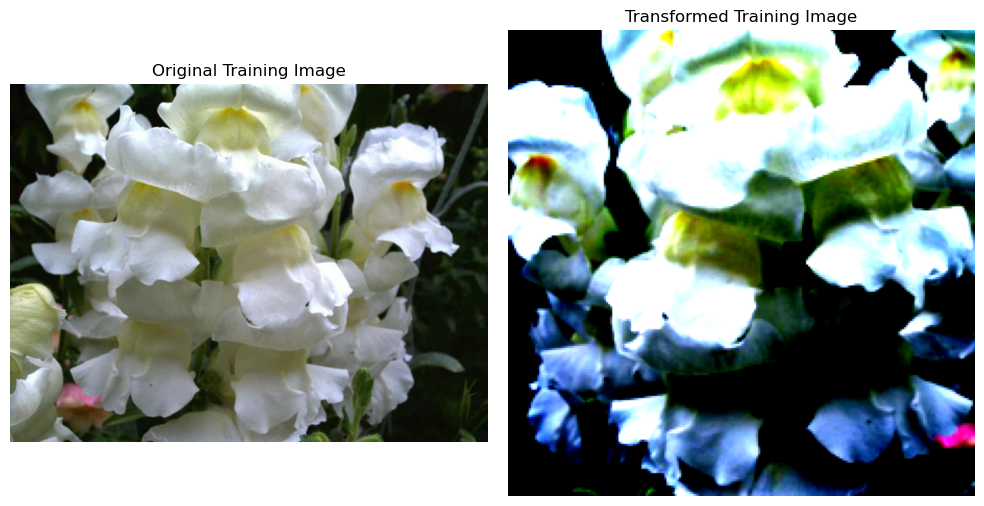

In [11]:
# Using the defined training transform (data_transform_train)
original_image, processed_image, denormalized_image = process_image(
    folder_number=11, 
    image_index=22, 
    subset_dir=args.train_dir, 
    transform=data_transform_train
)

# Visualize the original and processed training image (after full transformation) side by side
processed_image_np = processed_image.permute(1, 2, 0).cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_image)
axes[0].set_title("Original Training Image")
axes[0].axis("off")

axes[1].imshow(processed_image_np)
axes[1].set_title("Transformed Training Image")
axes[1].axis("off")

plt.tight_layout()
plt.show()

del processed_image_np

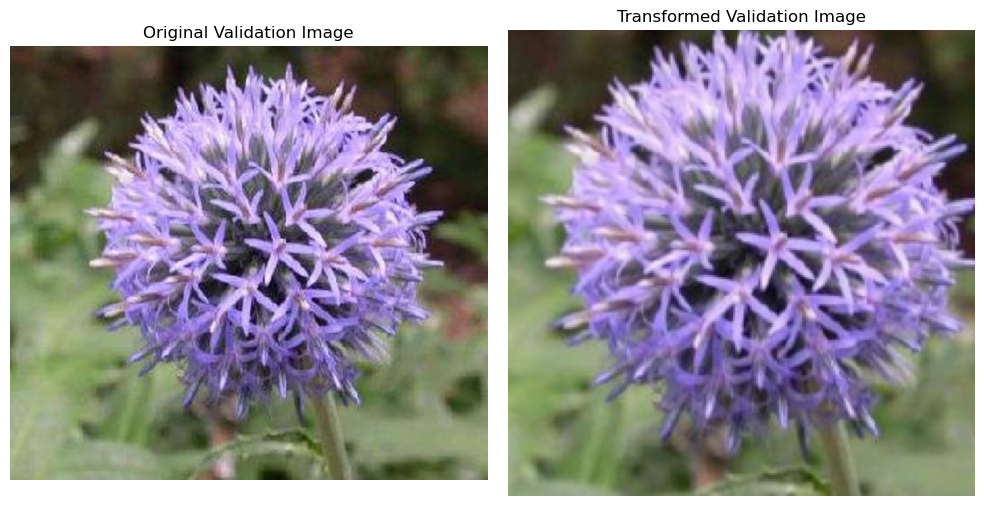

In [12]:
# Using the defined validation transform (data_transform_validtest)
original_image, processed_image, denormalized_image = process_image(
    folder_number=10, 
    image_index=9, 
    subset_dir=args.valid_dir, 
    transform=data_transform_validtest
)

# Visualize the original and transformed training image side by side

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_image)
axes[0].set_title("Original Validation Image")
axes[0].axis("off")

axes[1].imshow(denormalized_image)
axes[1].set_title("Transformed Validation Image")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [13]:
# Sanity check on number of images and labels

print(f"Train dataset size: {len(train_dataset)} images")
print(f"Validation dataset size: {len(valid_dataset)} images")
print(f"Test dataset size: {len(test_dataset)} images")
print(" ")
print(f"Number of class labels: {len(train_dataset.classes)}")  
print(f"All class labels: {train_dataset.classes}")  # Check class folder names
print(" ")
print(f"Class to index mapping: {train_dataset.class_to_idx}")  # Folder-to-label mapping


Train dataset size: 6552 images
Validation dataset size: 818 images
Test dataset size: 819 images
 
Number of class labels: 102
All class labels: ['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
 
Class to index mapping: {'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22,

In [14]:
# Sanity check on the batching of data

# Fetch a single batch from training data

images, labels = next(iter(train_dataloader))
print(f"Batch shape: {images.shape}")  # Expected: (32, 3, 224, 224) if batch_size=32
print(f"Labels shape: {labels.shape}")
print(f"Label values: {labels.numpy()}")  # Check assigned labels


Batch shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Label values: [  8  44  19  29  77  75  93   4  41  49  24  81 101  59  64  73  54  44
  53  16  72   9  43  97  12  90  90  87 100  64  38  78]


## **Dataset sizes are correct**
- **Train dataset:** 6,552 images  
- **Validation dataset:** 818 images  
- **Test dataset:** 819 images  

## **Class labels and mapping are fine**
- **Class labels:** Appear as expected (102 classes).  
- **Class-to-index mapping:** Folders are correctly assigned numerical labels.


## **Batch retrieval works**
- **Batch shape:**  `(32, 3, 224, 224)` matches batch_size=32  
- **Label values look as expected:** `[44 15 42 64 89 75 89 82 73 97 60 74 61 50 18 44 21 84 76  3 74 64 10 40
 39 78 74 21 97 77 66 66]`


In [15]:
# Delete large datasets or models (for running on CPU) 
# del train_dataset, valid_dataset
# Keep the test_dataset since it will be needed for inference

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [16]:
with open(args.flower_names, 'r') as f:
    flower_names = json.load(f)

print(f"Number of categories: {len(flower_names)}")
print(f"First 5 entries: {list(flower_names.items())[:10]}")

Number of categories: 102
First 5 entries: [('21', 'fire lily'), ('3', 'canterbury bells'), ('45', 'bolero deep blue'), ('1', 'pink primrose'), ('34', 'mexican aster'), ('27', 'prince of wales feathers'), ('7', 'moon orchid'), ('16', 'globe-flower'), ('25', 'grape hyacinth'), ('26', 'corn poppy')]


In [17]:
# Get system memory usage
mem = psutil.virtual_memory()
print(f"Total Memory: {mem.total / 1e9:.2f} GB")
print(f"Available Memory: {mem.available / 1e9:.2f} GB")
print(f"Used Memory: {mem.used / 1e9:.2f} GB")
print(f"Memory Usage: {mem.percent}%")


Total Memory: 6.30 GB
Available Memory: 1.30 GB
Used Memory: 5.00 GB
Memory Usage: 79.4%


In [18]:
process = psutil.Process(os.getpid())
print(f"Memory used by this notebook: {process.memory_info().rss / 1e6:.2f} MB")


Memory used by this notebook: 366.54 MB


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. 

## Note for Workspace users: 
If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

## Building the classifier based on pre-trained network

In [38]:
# Get command-line arguments
args = get_input_args()

# Ensure that the correct model is selected
if args.model == "resnet18":
    model = models.resnet18(pretrained=True)  # Load pretrained ResNet18
elif args.model == "resnet50":
    model = models.resnet50(pretrained=True)  # Load pretrained ResNet50

# FREEZE FEATURE EXTRACTOR
for param in model.parameters():
    param.requires_grad = False  # We freeze feature extractor layers so only classifier gets updated

# GET INPUT FEATURES FROM THE LAST LAYER
input_features = model.fc.in_features  # Extract number of input features dynamically

# DEFINE CUSTOM CLASSIFIER WITH RELU, DROPOUT, AND SOFTMAX
model.fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(input_features, 512)),  # Reduce feature size before classification
    ('relu', nn.ReLU()),  # Introduce non-linearity to help learn complex patterns
    ('drop', nn.Dropout(p=0.2)),  # Prevent overfitting by randomly deactivating neurons
    ('fc2', nn.Linear(512, 102)),  # Final output layer with 102 classes
    ('output', nn.LogSoftmax(dim=1))  # Converts outputs into class probabilities
]))

# MOVE MODEL TO GPU IF AVAILABLE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Ensure model runs on the correct device

# PRINT MODEL SUMMARY FOR DEBUGGING
print(f"\n✅ Loaded {args.model} successfully with custom classifier:\n")
print(model)


[INFO] Parsed Input Arguments:
  - Data folder: C:\Users\camel\Desktop\Projects\MY_COURSE\second_project\udacity_AIPND_train_flower_network\flowers
  - Training data folder: C:\Users\camel\Desktop\Projects\MY_COURSE\second_project\udacity_AIPND_train_flower_network\flowers\train
  - Validation data folder: C:\Users\camel\Desktop\Projects\MY_COURSE\second_project\udacity_AIPND_train_flower_network\flowers\valid
  - Testing data folder: C:\Users\camel\Desktop\Projects\MY_COURSE\second_project\udacity_AIPND_train_flower_network\flowers\test
  - Model architecture: resnet50
  - Flower names file: C:\Users\camel\Desktop\Projects\MY_COURSE\second_project\udacity_AIPND_train_flower_network\cat_to_name.json



C:\Users\camel\anaconda3\envs\my_course\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\camel\anaconda3\envs\my_course\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



✅ Loaded resnet50 successfully with custom classifier:

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
   

## Training the classifier

In [23]:
# Define loss function (Negative Log Likelihood)
criterion = nn.NLLLoss()

# Define optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model.fc.parameters(), lr=0.003, weight_decay=5e-5)  # Regularization added --> 1e-4

# Define learning rate scheduler (Reduces `lr` every 5 epochs)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Early Stopping Variables
best_val_loss = float("inf")  # Initialize with a high value
patience = 3  # Number of epochs to wait before stopping
patience_counter = 0

# Number of training epochs
epochs = 30  # Increase epochs since early stopping will cut it short if needed

# Training Loop
for epoch in range(epochs):
    running_loss = 0
    correct = 0
    total = 0

    # Training Mode
    model.train()

    for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Training]", leave=True):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(output, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = running_loss / len(train_dataloader)
    train_accuracy = correct / total * 100

    # Validation Phase
    model.eval()  
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  
        for images, labels in tqdm(valid_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=True):
            images, labels = images.to(device), labels.to(device)

            output = model(images)
            loss = criterion(output, labels)
            val_loss += loss.item()

            _, preds = torch.max(output, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(valid_dataloader)
    val_accuracy = correct / total * 100

    print(f"\n📢 Epoch {epoch+1}/{epochs}:")
    print(f"   🟢 Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}%")
    print(f"   🔵 Valid Loss: {avg_val_loss:.4f} | Valid Acc: {val_accuracy:.2f}%\n")

    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss  # Update best validation loss
        patience_counter = 0  # Reset counter
        torch.save(model.state_dict(), "best_model.pth")  # Save best model
        print("✅ Model improved! Best model saved.")
    else:
        patience_counter += 1  # Increment patience counter
        print(f"🚨 No improvement for {patience_counter} epoch(s).")

    if patience_counter >= patience:
        print("\n⏹️ Early stopping triggered. Stopping training.")
        break  # Stop training if validation loss hasn't improved for `patience` epochs

Epoch 1/30 [Validation]: 100%|██████████| 26/26 [00:59<00:00,  2.28s/it]



📢 Epoch 1/30:
   🟢 Train Loss: 3.0145 | Train Acc: 29.59%
   🔵 Valid Loss: 1.4066 | Valid Acc: 63.81%

✅ Model improved! Best model saved.


Epoch 2/30 [Validation]: 100%|██████████| 26/26 [00:58<00:00,  2.27s/it]



📢 Epoch 2/30:
   🟢 Train Loss: 1.5184 | Train Acc: 57.97%
   🔵 Valid Loss: 0.8587 | Valid Acc: 77.75%

✅ Model improved! Best model saved.


Epoch 3/30 [Validation]: 100%|██████████| 26/26 [00:58<00:00,  2.27s/it]



📢 Epoch 3/30:
   🟢 Train Loss: 1.2391 | Train Acc: 63.77%
   🔵 Valid Loss: 0.7815 | Valid Acc: 77.02%

✅ Model improved! Best model saved.


Epoch 4/30 [Validation]: 100%|██████████| 26/26 [00:59<00:00,  2.31s/it]



📢 Epoch 4/30:
   🟢 Train Loss: 1.0857 | Train Acc: 68.06%
   🔵 Valid Loss: 0.6755 | Valid Acc: 82.15%

✅ Model improved! Best model saved.


Epoch 5/30 [Validation]: 100%|██████████| 26/26 [01:01<00:00,  2.36s/it]



📢 Epoch 5/30:
   🟢 Train Loss: 0.9353 | Train Acc: 72.24%
   🔵 Valid Loss: 0.6232 | Valid Acc: 82.89%

✅ Model improved! Best model saved.


Epoch 6/30 [Validation]: 100%|██████████| 26/26 [01:00<00:00,  2.32s/it]



📢 Epoch 6/30:
   🟢 Train Loss: 0.9323 | Train Acc: 72.92%
   🔵 Valid Loss: 0.6116 | Valid Acc: 82.40%

✅ Model improved! Best model saved.


Epoch 7/30 [Validation]: 100%|██████████| 26/26 [01:00<00:00,  2.34s/it]



📢 Epoch 7/30:
   🟢 Train Loss: 0.8946 | Train Acc: 72.86%
   🔵 Valid Loss: 0.6224 | Valid Acc: 82.89%

🚨 No improvement for 1 epoch(s).


Epoch 8/30 [Validation]: 100%|██████████| 26/26 [01:00<00:00,  2.32s/it]



📢 Epoch 8/30:
   🟢 Train Loss: 0.8742 | Train Acc: 74.01%
   🔵 Valid Loss: 0.5542 | Valid Acc: 86.43%

✅ Model improved! Best model saved.


Epoch 9/30 [Validation]: 100%|██████████| 26/26 [01:00<00:00,  2.32s/it]



📢 Epoch 9/30:
   🟢 Train Loss: 0.8244 | Train Acc: 74.76%
   🔵 Valid Loss: 0.5733 | Valid Acc: 84.47%

🚨 No improvement for 1 epoch(s).


Epoch 10/30 [Validation]: 100%|██████████| 26/26 [00:53<00:00,  2.04s/it]



📢 Epoch 10/30:
   🟢 Train Loss: 0.7965 | Train Acc: 75.40%
   🔵 Valid Loss: 0.5170 | Valid Acc: 85.57%

✅ Model improved! Best model saved.


Epoch 11/30 [Validation]: 100%|██████████| 26/26 [00:58<00:00,  2.24s/it]



📢 Epoch 11/30:
   🟢 Train Loss: 0.7885 | Train Acc: 76.33%
   🔵 Valid Loss: 0.5397 | Valid Acc: 84.47%

🚨 No improvement for 1 epoch(s).


Epoch 12/30 [Validation]: 100%|██████████| 26/26 [01:09<00:00,  2.66s/it]



📢 Epoch 12/30:
   🟢 Train Loss: 0.7951 | Train Acc: 75.87%
   🔵 Valid Loss: 0.5618 | Valid Acc: 85.09%

🚨 No improvement for 2 epoch(s).


Epoch 13/30 [Validation]: 100%|██████████| 26/26 [00:59<00:00,  2.27s/it]


📢 Epoch 13/30:
   🟢 Train Loss: 0.7603 | Train Acc: 76.80%
   🔵 Valid Loss: 0.5708 | Valid Acc: 83.99%

🚨 No improvement for 3 epoch(s).

⏹️ Early stopping triggered. Stopping training.


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [23]:
# TODO: Do validation on the test set
def evaluate_on_test(model, test_dataset, test_loader):
    """
    Runs the model over the entire test dataset and computes accuracy.
    
    - Extracts the top-1 prediction for each image.
    - Compares it with the correct flower class (folder name).
    - Returns overall test accuracy.

    Arguments:
      model: The trained PyTorch model.
      test_dataset: The ImageFolder dataset (contains class-to-index mapping).
      test_loader: DataLoader for test dataset.

    Returns:
      test_accuracy: The overall accuracy on the test set.
    """
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    # Invert class_to_idx mapping to get actual flower numbers
    idx_to_class = {value: key for key, value in test_dataset.class_to_idx.items()}

    with torch.no_grad():  # No gradient calculation for efficiency
        for images, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
            images, labels = images.to("cpu"), labels.to("cpu")  # Move to CPU for testing
            
            # Forward pass
            output = model(images)
            probs = torch.exp(output)  # Convert log-softmax to probabilities
            
            # Get top-1 prediction
            _, preds = probs.topk(1, dim=1)  # Extracts top prediction index
            
            # Convert predictions to class labels
            predicted_classes = [idx_to_class[idx.item()] for idx in preds.squeeze()]
            actual_classes = [idx_to_class[idx.item()] for idx in labels]

            # Compare predictions with actual labels
            correct += sum(p == a for p, a in zip(predicted_classes, actual_classes))
            total += labels.size(0)

    # Compute accuracy
    test_accuracy = (correct / total) * 100
    print(f"\n✅ Model Test Accuracy: {test_accuracy:.2f}%")
    return test_accuracy

In [24]:
# Run the evaluation function on test
test_accuracy = evaluate_on_test(model, test_dataset, test_dataloader)


Evaluating on Test Set: 100%|██████████| 26/26 [02:35<00:00,  5.99s/it]


✅ Model Test Accuracy: 87.30%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [25]:
# TODO: Save the checkpoint 

# Define the optimizer again (it must match the training setup)
optimizer = optim.Adam(model.fc.parameters(), lr=0.003, weight_decay=5e-5)  

def update_checkpoint(filepath, model, optimizer, epochs, dataset):
    """
    Loads an existing model checkpoint, adds missing data (optimizer, hyperparameters, class_to_idx),
    and saves it again without losing the trained weights.

    Arguments:
        filepath: Path to the saved model checkpoint.
        model: The trained PyTorch model.
        optimizer: The optimizer used for training.
        epochs: Number of epochs the model was trained for.
        dataset: The dataset object containing class_to_idx mapping.
    """
    # Load existing state_dict
    checkpoint = torch.load(filepath, map_location=torch.device("cpu"))

    # Create new checkpoint with additional data
    new_checkpoint = {
        "arch": "resnet50",  # Update based on model type
        "state_dict": checkpoint,  # Keep existing model weights
        "optimizer_state": optimizer.state_dict(),  # Save optimizer state
        "epochs": epochs,  # Save number of training epochs
        "class_to_idx": dataset.class_to_idx,  # Save class mapping
        "hyperparameters": {
            "learning_rate": optimizer.param_groups[0]["lr"],
            "dropout": 0.2,  # Update if different
            "batch_size": 16  # Update if different
        }
    }

    # Save the updated checkpoint
    new_filepath = "final_best_model.pth"
    torch.save(new_checkpoint, new_filepath)
    print(f"\n✅ Checkpoint updated and saved as: {new_filepath}")

# Run the update function
update_checkpoint("best_model.pth", model, optimizer, epochs=30, dataset=train_dataset)




✅ Checkpoint updated and saved as: final_best_model.pth


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [26]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    """Loads a trained model from a checkpoint file."""
    checkpoint = torch.load(filepath, map_location=torch.device("cpu"))  # Ensure compatibility

    # Rebuild the same model architecture used in training
    model = models.resnet50(pretrained=True)  # Must match the architecture used before
    input_features = model.fc.in_features

    # Match classifier naming exactly as in the saved model
    model.fc = torch.nn.Sequential(OrderedDict([
        ('fc1', torch.nn.Linear(input_features, 512)),  
        ('relu', torch.nn.ReLU()),
        ('drop', torch.nn.Dropout(0.2)),
        ('fc2', torch.nn.Linear(512, 102)),  
        ('output', torch.nn.LogSoftmax(dim=1))
    ]))

    # Load the trained weights
    model.load_state_dict(checkpoint)

    model.eval()  # Set to evaluation mode (important!)
    return model

In [27]:
# Load model
model = load_checkpoint("best_model.pth")
print("\n✅ Model loaded successfully!")


✅ Model loaded successfully!


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 


And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

### **The _process_image_ function has already been defined when running sanity checks ahead of training ** 

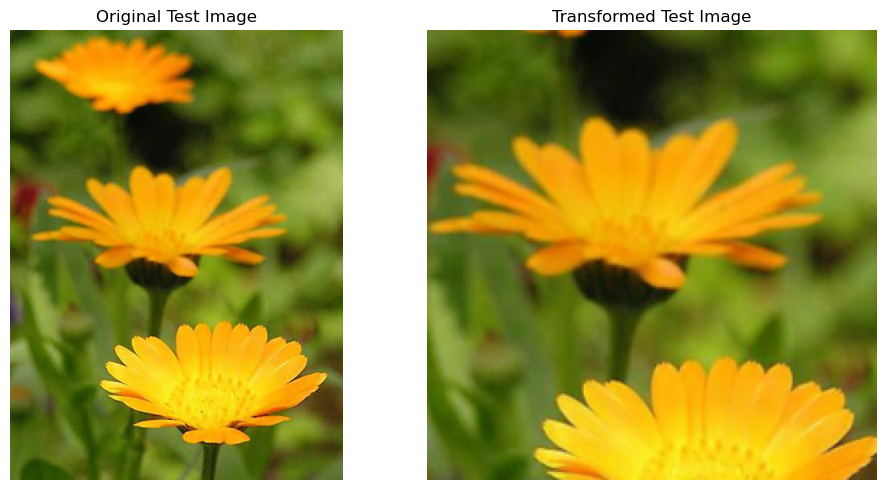

In [28]:
# Using the defined test transform (data_transform_validtest)
original_image, processed_image, denormalized_image = process_image(
    folder_number=5, 
    image_index=2, 
    subset_dir=args.test_dir, 
    transform=data_transform_validtest
)

# Visualize the original and transformed training image side by side

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_image)
axes[0].set_title("Original Test Image")
axes[0].axis("off")

axes[1].imshow(denormalized_image)
axes[1].set_title("Transformed Test Image")
axes[1].axis("off")

plt.tight_layout()
plt.show()

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [29]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

<Axes: >

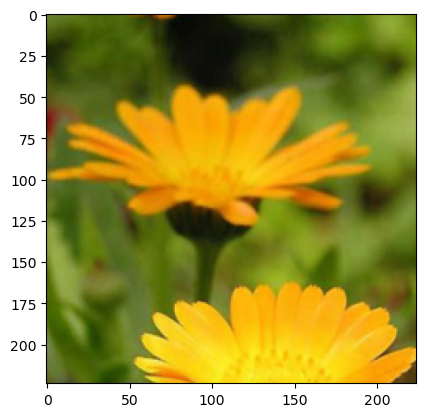

In [30]:
imshow(processed_image)  # Run this separately in a cell

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [31]:
def predict(folder_number, image_index, subset_dir, dataset, model, topk=5):
    ''' 
    Predict the class (or classes) of an image using a trained deep learning model.
    
    Inputs:
      - folder_number (int): The flower category folder (1 to 102)
      - image_index (int): The index of the image within that folder
      - subset_dir (str): The directory of the dataset (e.g., args.test_dir)
    
    Returns:
      top_probs: List of top K probabilities.
      top_classnames: List of corresponding class labels.
    '''
    # Use the existing process_image function to load and transform the image.
    _, processed_image, _ = process_image(folder_number, image_index, subset_dir, data_transform_validtest)
    
    # Ensure the processed tensor has the correct shape for the model
    image = processed_image.unsqueeze(0).to(torch.device("cpu"))
    
    model.eval()  # Set model to evaluation mode
    
    with torch.no_grad():
        output = model.forward(image)
    
    # Convert log-softmax output to probabilities
    probs = torch.exp(output)
    
    # Get top K probabilities and indices
    top_probs, top_indices = probs.topk(topk, dim=1)
    top_probs = top_probs.squeeze().tolist()
    top_indices = top_indices.squeeze().tolist()
    
    # Invert the dataset's class_to_idx mapping to get idx_to_class
    idx_to_class = {value: key for key, value in dataset.class_to_idx.items()}
    top_classnames = [idx_to_class[idx] for idx in top_indices]
    
    return top_probs, top_classnames

In [32]:
# Recreate the test dataset if it was deleted to make room in the CPU memory:
# test_dataset = torchvision.datasets.ImageFolder(root=args.test_dir, transform=data_transform_validtest)

# Pass folder number, image index, test directory and model
probs, classes = predict(5, 2, args.test_dir, test_dataset, model)

print("\n✅ Predictions on Test Data Completed!")
print(f"Top {len(probs)} Classes: {classes}")
print(f"Probabilities: {probs}")


✅ Predictions on Test Data Completed!
Top 5 Classes: ['5', '71', '65', '59', '50']
Probabilities: [0.933673083782196, 0.020599406212568283, 0.017732033506035805, 0.008571016602218151, 0.006136843003332615]


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [33]:
def display_predictions(folder_number, image_index, subset_dir, dataset, model, cat_to_name, topk=5):
    """
    Displays an image alongside the top-K predicted classes & their probabilities.
    
    Inputs:
      - folder_number (int): The flower category folder (1 to 102). If out of range, defaults to 1.
      - image_index (int): The index of the image within that folder (0 for first image). If out of range, defaults to 0.
      - subset_dir (str): The directory of the dataset (e.g., args.test_dir).
      - dataset: The ImageFolder dataset (used for its class-to-index mapping).
      - model: Trained model for inference.
      - cat_to_name: Dictionary mapping class labels to actual flower names.
      - topk (int): Number of top predictions to display (default: 5).
    """
    # -- 1) Use the same out-of-range logic used in process_image/predict --
    if folder_number < 1 or folder_number > 102:
        print(f"Warning: folder_number {folder_number} is out of range. Defaulting to 1 (first folder).")
        folder_number = 1

    class_folder = os.path.join(subset_dir, str(folder_number))
    if not os.path.isdir(class_folder):
        raise ValueError(f"Folder '{class_folder}' does not exist!")

    image_files = sorted(os.listdir(class_folder))
    if image_index >= len(image_files):
        print(f"Warning: image_index {image_index} is out of range for folder '{class_folder}'. Defaulting to 0 (first image).")
        image_index = 0

    # -- 2) Load and transform the image using the final, valid folder_number/index --
    original_image, processed_image, denorm_image = process_image(
        folder_number, image_index, subset_dir, data_transform_validtest
    )
    
    actual_class = str(folder_number)
    actual_label = cat_to_name.get(actual_class, "Unknown")

    # -- 3) Run prediction with the same validated folder_number/index --
    probs, classes = predict(folder_number, image_index, subset_dir, dataset, model, topk)

    # Convert predicted class labels (e.g. '5', '65') to flower names.
    predicted_flowers = [cat_to_name.get(str(cls), str(cls)) for cls in classes]

    # Sort predictions in descending order (highest probability first).
    sorted_indices = np.argsort(probs)[::-1]
    sorted_probs = [probs[i] for i in sorted_indices]
    sorted_flowers = [predicted_flowers[i] for i in sorted_indices]

    # Determine correctness of top prediction.
    top_prediction = sorted_flowers[0]
    correct_prediction = (top_prediction == actual_label)
    title_color = "green" if correct_prediction else "red"
    correctness_marker = "- Right!" if correct_prediction else "- Wrong!"

    # -- 4) Plot the de-normalized image + horizontal bar chart of top-K predictions --
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Left: De-normalized image
    axes[0].imshow(denorm_image)
    axes[0].axis("off")
    axes[0].set_title(f"Actual: {actual_label} {correctness_marker}",
                      fontsize=14, fontweight="bold", color=title_color)

    # Right: Probability bar chart
    axes[1].barh(sorted_flowers[::-1], sorted_probs[::-1], color="skyblue")
    axes[1].set_xlabel("Prediction Probability", fontsize=12)
    axes[1].set_xlim(0, 1)
    axes[1].set_title(f"Top-{topk} Predictions", fontsize=14, fontweight="bold")

    plt.tight_layout()
    plt.show()


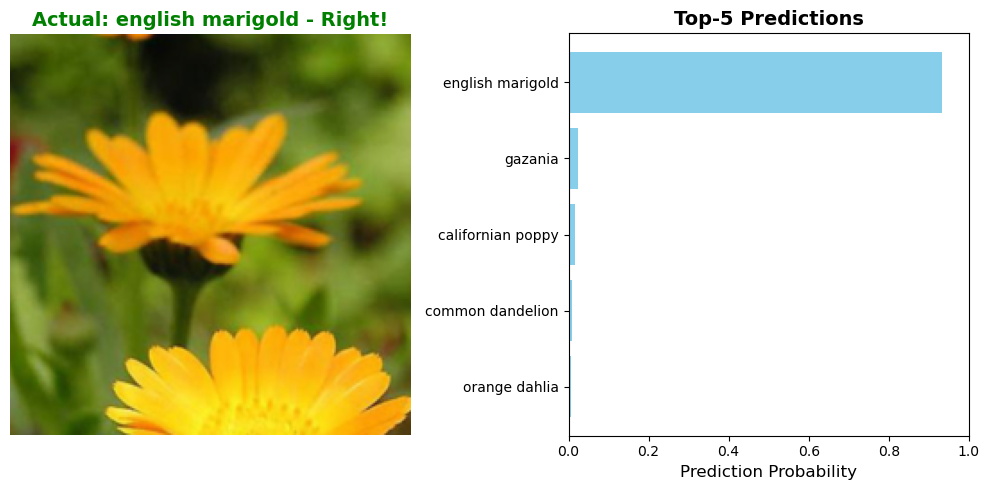

In [65]:
# Load category-to-name mapping.
with open("cat_to_name.json", "r") as f:
    cat_to_name = json.load(f)

# For example: Display predictions for an image in folder 5 at index 2.
display_predictions(folder_number=5, image_index=2, subset_dir=args.test_dir, dataset=test_dataset, model=model, cat_to_name=cat_to_name, topk=5)